In [47]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import plotly.graph_objects as go

image_path = 'image1.jpg'

# Coppelia Remote Client
client = RemoteAPIClient()
sim = client.getObject('sim')

# Get the vision sensor handle
vision_sensor_handle = sim.getObject('/Vision_sensor') 
chessboard_handle = sim.getObject('/Cuboid[3]/Dummy')
cubo = sim.getObject('/Cuboid[3]')

In [3]:
class Feed: 
    def __init__(self, title, res=(480,480), graphical=False):
        self.title = title
        self.graphical = graphical # Toggle to activate graphical mode
        self.res = res # Change feed dimensions 

        # Create Figure 
        self.figure = go.Figure(
            layout=go.Layout(
                height=700, 
                width=900, 
                title=go.layout.Title(text=self.title)
            )
        )

        self.figure.update_yaxes(
            scaleanchor="x",
            scaleratio=1
        )
        
        self.figure.update_layout(
            xaxis_title='x',
            yaxis_title='y',
            plot_bgcolor='white',
            font=dict(
                family='Arial',
                size=15,
                color='black'
            ),
            xaxis=dict(
                gridcolor='lightgray',
                dtick = res[0]/10,
                range=[0, self.res[0]]
            ),
            yaxis=dict(
                gridcolor='lightgray',
                dtick = res[1]/10,
                range=[self.res[1], 0]
            )
        )

        self.figure.add_shape(
            type='rect',
            x0=0, y0=0, x1=res[0], y1=res[1],
            line=dict(color='black'),
        )


    def add_points(self, point, name, color=None):
        self.figure.add_trace(
            go.Scatter(
                x=point[0],
                y=point[1],
                mode='markers',
                marker=dict(
                    size=5,
                    opacity=0.80,
                    color=color
                ),
                name=name,
                legendgroup='Points',
                legendgrouptitle_text='Points',
                showlegend=self.graphical
            )
        )

In [4]:
# Random rotation matrix
def randR():
    return Rotation.from_euler('xyz', [np.random.randint(0, 360), np.random.randint(0, 360), np.random.randint(0, 360)], degrees=True).as_matrix()

In [5]:
# Random translation matrix
def randt(L): # Confined in a cube with an edge of length L
    return np.array([[2*L*np.random.random_sample()-L] for _ in range(3)])

In [6]:
# Make coordinates homogeneous
def to_homo(points):
    return np.vstack((points, np.ones(points.shape[1])))

In [7]:
# Joins the rotation and translation matrices to make a homogeneous transformation
def join_homo(R, t):
    return np.vstack((np.hstack((R, t)), np.array([0, 0, 0, 1])))

In [8]:
# Extract the rotation and translation matrices from the homogeneous transformation
def split_homo(H):
    return H[0:3, 0:3], H[0:3 , [-1]]

In [9]:
# Returns the inverse of a homogeneous transformation matrix
def inverse_homo(H):
    R, t = split_homo(H)
    
    return join_homo(R.T, -R.T @ t)

In [10]:
def build_intrinsic_matrix(fov_degrees, resolution):
    fov_radians = np.radians(fov_degrees)

    f_x = resolution[0]/(2*np.tan(fov_radians/2))
    f_y = resolution[1]/(2*np.tan(fov_radians/2))

    o_x = resolution[0]/2
    o_y = resolution[1]/2

    camera_matrix = np.array([[-f_x,   0, o_x, 0],
                              [  0, -f_y, o_y, 0],
                              [  0,    0,   1, 0]])

    return camera_matrix

def build_extrinsic_matrix(vision_sensor_handle, chessboard_handle = sim.handle_world):
    camera_pose = np.vstack((np.array(sim.getObjectMatrix(vision_sensor_handle, chessboard_handle)).reshape((3,4)), np.array([0, 0, 0, 1])))

    return camera_pose

def build_projection_matrix(intrinsic_matrix, extrinsic_matrix):
    projection_matrix = intrinsic_matrix @ inverse_homo(extrinsic_matrix) 

    return projection_matrix

def perspective_projection(points, projection_matrix):
    projected_point = projection_matrix @ points  # Project points to plane
    projected_point /= projected_point[-1]        # Normalize homogeneous coordinates
    projected_point = projected_point[:-1, :]     # Discard the last row
    #projected_point = projected_point.astype(int) # Cast as interger
    
    return projected_point

In [11]:
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize # Square size não interfere na calibração -> somente um fator de escala
                       # o square size não é utilizado na calibração dos cara de stanford
    return X

---
## Corners detectors

In [ ]:
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detecta bordas usando o filtro de Sobel
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
edges = cv2.magnitude(sobel_x, sobel_y)

# Normaliza e converte para uma imagem de 8 bits
edges = np.uint8(255 * edges / np.max(edges))

cv2.imshow('Edges', edges)
cv2.waitKey(0)
cv2.destroyAllWindows() #close the image window

# Detecção de cantos usando a técnica de Harris
corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
corners = cv2.dilate(corners, None)

img_corners = image.copy()
img_corners[corners > 0.01 * corners.max()] = [0, 0, 255]

cv2.imshow('Corners', img_corners)
cv2.waitKey(0)
cv2.destroyAllWindows() #close the image window

ret, corners = cv2.threshold(corners, 0.01 * corners.max(), 255, 0)
corners = np.uint8(corners)
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)

img_refined_corners = image.copy()
for corner in corners:
    cv2.circle(img_refined_corners, tuple(int(i) for i in corner), 3, (0, 255, 0), -1)

cv2.imshow('Refined Corners', img_refined_corners)
cv2.waitKey(0)
cv2.destroyAllWindows() #close the image window

board_size = (7,7)

corners = np.reshape(corners, (-1, 2))
sorted_corners = []
for y in range(board_size[1]):
    row = sorted(corners[y * board_size[0]:(y + 1) * board_size[0]], key=lambda x: x[0])
    sorted_corners.extend(row)

img_sorted_corners = image.copy()
for corner in sorted_corners:
    cv2.circle(img_sorted_corners, tuple(int(i) for i in corner), 3, (255, 0, 0), -1)
cv2.imshow('Sorted Corners', img_sorted_corners)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [88]:
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  

cv2.imshow('Edges', gray)
cv2.waitKey(0)
cv2.destroyAllWindows() #close the image window

flags = cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_ACCURACY


# Find the chess board corners
ret, cornerSB = cv2.findChessboardCornersSB(gray, (7,7), flags )
ret

True

In [89]:
cornerSB

array([[[286.49313, 235.52312]],

       [[321.538  , 235.52977]],

       [[356.51627, 235.5247 ]],

       [[391.517  , 235.51256]],

       [[425.57138, 235.53926]],

       [[460.49118, 235.5175 ]],

       [[495.5726 , 235.53235]],

       [[286.50363, 270.51025]],

       [[321.52133, 270.49503]],

       [[356.51038, 270.50082]],

       [[391.54373, 270.51154]],

       [[425.54706, 270.50406]],

       [[460.51398, 270.50922]],

       [[495.5614 , 270.50095]],

       [[286.50748, 305.5328 ]],

       [[321.51736, 305.53204]],

       [[356.50177, 305.52942]],

       [[391.534  , 305.53738]],

       [[425.56177, 305.53162]],

       [[460.50827, 305.5347 ]],

       [[495.5695 , 305.54614]],

       [[286.49384, 340.5114 ]],

       [[321.53046, 340.5167 ]],

       [[356.5005 , 340.52075]],

       [[391.53677, 340.5182 ]],

       [[425.56726, 340.50354]],

       [[460.5044 , 340.51917]],

       [[495.56146, 340.51227]],

       [[286.49017, 374.52045]],

       [[321.5

In [103]:
flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE 	

ret, cornerN_noflag = cv2.findChessboardCorners(gray, (7,7), None)
ret, cornerN_flag = cv2.findChessboardCorners(gray, (7,7), flags)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

if ret:
    cornerN_noflag = cv2.cornerSubPix(gray,cornerN_noflag, (11,11), (-1,-1), criteria)
    cornerN_flag = cv2.cornerSubPix(gray,cornerN_flag, (11,11), (-1,-1), criteria)

---

In [12]:
# Dados do Coppelia
# Declare intrinsic parameters
fov_degrees = 60.0
resolution = (720,720)

# Generate intrinsic parameters matrix
intrinsic_matrix = build_intrinsic_matrix(fov_degrees, resolution) 
print(intrinsic_matrix)

[[-623.53829072    0.          360.            0.        ]
 [   0.         -623.53829072  360.            0.        ]
 [   0.            0.            1.            0.        ]]


In [45]:
import time

images_points = []
world_points = []

def sum_coord(A, B):
    for coord in range(len(A)):
        B[coord] += A[coord]
        
    return B 

patternSize = (7,7)

# Start simulation in CoppeliaSim
sim.startSimulation()

# Number of calibration images
number_of_images = 1

# See the Vision sensor image
time.sleep(0.75)

for i in range(number_of_images):
    
    p=sim.getObjectPosition(cubo,-1)

    ds = randt(0.2)
    coord = sum_coord(p, ds).tolist()
    coord = [coord[0][0], coord[1][0], coord[2][0]]
    
    sim.setObjectPosition(cubo,-1, coord)
    
    extrinsic_matrix = build_extrinsic_matrix(vision_sensor_handle, chessboard_handle)
    
    projection_matrix = build_projection_matrix(intrinsic_matrix, extrinsic_matrix)

    board_points = construct3DPoints(patternSize = (7,7), squareSize = 0.1)

    world_points.append(board_points)
    
    points_to_project = to_homo(board_points.T) 

    projected_points = perspective_projection(points_to_project, projection_matrix)
    projected_points = projected_points.T

    images_points.append(projected_points)
    
    img, resX, resY = sim.getVisionSensorCharImage(vision_sensor_handle)
    img = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)
    img = cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0)
    cv2.imwrite('image1.jpg', img)
    time.sleep(0.75)

sim.stopSimulation()

corrected_image_points_vector = []
corrected_world_points_vector = []
for image in images_points:
    image = image.astype(np.float32)
    corrected_image_points_vector.append(image.reshape(49,1,2))

for world in world_points:
    world = world.astype(np.float32)
    corrected_world_points_vector.append(world.reshape(49,1,3))

In [46]:
# Create the image viewer
image = Feed('Camera Image', resolution, graphical=True)

# Adding the projected points to the scene
image.add_points(projected_points.T, 'Image Point', 'black')

# Plot image
image.figure.show(renderer='notebook_connected')

---

In [90]:
# Create the image viewer
image = Feed('Camera Image', resolution, graphical=True)

# Adding the projected points to the scene
image.add_points(cornerSB.reshape(49,2).T, 'Image Point', 'black')

# Plot image
image.figure.show(renderer='notebook_connected')

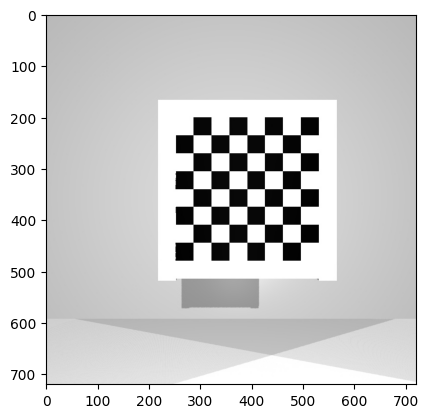

In [50]:
%matplotlib inline

import matplotlib.image as mpimg

# Carregar a imagem
img = mpimg.imread('image1.jpg')

# Plotar a imagem
plt.imshow(img)


In [99]:
projected_points = projected_points.astype(np.float32)

In [102]:
from math import sqrt
# Find the Euclidean Distance between projected and detected image points 
errorSB = cv2.norm(projected_points, cornerSB.reshape(49,2), normType= cv2.NORM_L2) / sqrt(len(projected_points))
errorN = cv2.norm(projected_points, cornerN.reshape(49,2), normType= cv2.NORM_L2) / sqrt(len(projected_points))

0.7398521167893536